Initializing VectorStoreManager for index 'au-blog-rag-fine-tuned'.
Index 'au-blog-rag-fine-tuned' loaded.
Total vectors: 1051
Found 1051 documents.
Unique URLS: 100
Total documents: 1051

Total length: 799470
Average length: 760.6755470980019
Max length: 999

Total tokens: 171716
Average tokens: 163.383444338725
Max tokens: 297


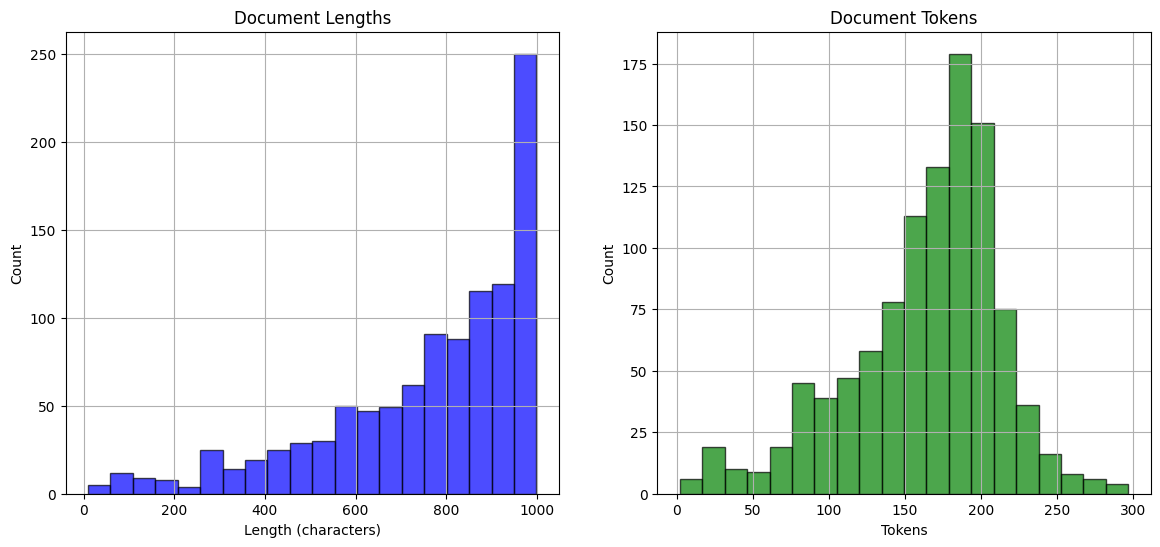

In [1]:
import tiktoken
import matplotlib.pyplot as plt
import pandas as pd

from src.utils.vector_store_manager import VectorStoreManager
from src.utils.configuration import LoaderConfiguration
from langchain_core.runnables import RunnableConfig
from dotenv import load_dotenv
load_dotenv()

config = LoaderConfiguration().from_runnable_config(
    RunnableConfig(configurable={"index_name": "au-blog-rag-fine-tuned"})
)
document_processor = VectorStoreManager(index_name="au-blog-rag-fine-tuned", configuration=config)

def count_tokens(text, model="gpt-4o-mini"):
    encoding = tiktoken.encoding_for_model(model)
    t = encoding.encode(text)
    return len(t)

docs = document_processor.get_all_documents()
print(f"Unique URLS: {len(set([doc['metadata']['source'] for doc in docs]))}")

lengths = [len(doc['content']) for doc in docs]
tokens = [count_tokens(doc['content']) for doc in docs]


fig, axes = plt.subplots(1, 2, figsize=(14, 6))
pd.Series(lengths).hist(bins=20, alpha=0.7, color='blue', edgecolor='black', ax=axes[0])
axes[0].set_title('Document Lengths')
axes[0].set_xlabel('Length (characters)')
axes[0].set_ylabel('Count')

pd.Series(tokens).hist(bins=20, alpha=0.7, color='green', edgecolor='black', ax=axes[1])
axes[1].set_title('Document Tokens')
axes[1].set_xlabel('Tokens')
axes[1].set_ylabel('Count')


print(f"Total documents: {len(lengths)}\n")

print(f"Total length: {sum(lengths)}")
print(f"Average length: {sum(lengths)/len(lengths)}")
print(f"Max length: {max(lengths)}\n")

print(f"Total tokens: {sum(tokens)}")
print(f"Average tokens: {sum(tokens)/len(tokens)}")
print(f"Max tokens: {max(tokens)}")

In [5]:
import requests
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv("LANGCHAIN_API_KEY")
api_url = os.getenv("API_URL")

# Create thread
print("Creating thread")
url = f"{api_url}/threads/"
headers = {"X-Api-Key": api_key}
payload = {
    "thread_id": "",
    "metadata": {},
    "if_exists": "raise"
}
response = requests.post(url, headers=headers, json=payload)
thread_id = response.json()["thread_id"]
print(response)

# Background run
print("Creating background run")
url = f"{api_url}/threads/{thread_id}/runs"
headers = {"X-Api-Key": api_key}
payload = {
    "thread_id": thread_id,
    "assistant_id": "retrieval_graph",
    "input": {
        "query": "We're discussing with a prospect client that wants to implement an AI feature in the app. Please show me article about our experience and knowledge."
    },
    "metadata": {
        "debug_info": "Notebook run third"
    },
    "config": {
        "index_name": "au-blog-rag-fine-tuned",
        "embedding_model": "wylupek/au-blog-rag-embedder",
    }
}
response = requests.post(url, headers=headers, json=payload)
run_id = response.json()["run_id"]
print(response)

# Waiting for run to finish
print("Joining background run")
url = f"{api_url}/threads/{thread_id}/runs/{run_id}/join"
headers = {"X-Api-Key": api_key}
payload = {
    "thread_id": thread_id,
    "run_id": run_id
}
response = requests.get(url, headers=headers, json=payload)
print(response)

Creating thread
<Response [200]>
Creating background run
<Response [200]>
Joining background run
<Response [200]>


In [8]:
response.json()

{'sitemap_entries': [{'url': 'https://tech.appunite.com/blog/how-agents-are-reshaping-the-future-of-saas-and-business-software-ai',
   'lastmod': None,
   'score': 0.49690738185318234},
  {'url': 'https://tech.appunite.com/blog/google-i-o-2024-keynote-announcements',
   'lastmod': None,
   'score': 0.3576884022811443},
  {'url': 'https://tech.appunite.com/blog/transform-your-app-with-on-device-machine-learning',
   'lastmod': None,
   'score': 0.30000289036077565}],
 'query': "We're discussing with a prospect client that wants to implement an AI feature in the app. Please show me article about our experience and knowledge.",
 'generated_queries': ['Can you provide articles that showcase our expertise in implementing AI features in applications for potential clients?',
  'What resources do we have that highlight our experience with integrating AI functionalities into apps for clients?',
  "I'm looking for documentation that details our knowledge and experience in adding AI features to a

In [9]:
json = response.json()

In [11]:
json["analyses"]

[{'url': 'https://tech.appunite.com/blog/how-agents-are-reshaping-the-future-of-saas-and-business-software-ai',
  'score': 0.49690738185318234,
  'decision': True,
  'summary': 'The article discusses how AI is transforming the SaaS industry, moving away from traditional seat-based pricing to more dynamic, usage-based models. It highlights the shift from user-guided workflows to autonomous AI agents, which are becoming specialized in industry-specific tasks. This evolution allows businesses to focus more on strategic initiatives rather than routine operations. The article emphasizes the importance of adapting to these changes to remain competitive, suggesting that AI integration can lead to significant advantages and improved business outcomes.',
  'analysis': 'The article illustrates our understanding of the evolving SaaS landscape influenced by AI. It explains how AI is changing pricing models from static to dynamic, emphasizing the need for SaaS companies to adapt. It also highlights